In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datalore.plot import *

In [ ]:
from datalore.display import *

In [ ]:
from scipy.stats import uniform, norm, geom, mannwhitneyu, ks_2samp
from scipy.linalg import cholesky

In [ ]:
from copy import copy
import time

In [ ]:
from PIL import Image

In [ ]:
import seaborn as sns

$\newcommand{\pr}{\mathbb{P}}$

In [ ]:
def square_loss(y, X, beta):
    r = y - X.dot(beta)
    return (r**2).sum()

In [ ]:
def eval_score(model, val, y_val):
    y_hat = model(val).squeeze()
    y_val = y_val.squeeze()
    return 1. - ((y_val-y_hat)**2).mean()/np.var(y_val)

In [ ]:
def clip(x, min_x, max_x):
    x_ = copy(x)
    x_[x_ < min_x] = min_x
    x_[x_ > max_x] = max_x
    return x_

In [ ]:
def plot_map(data, zoom=6, legend=True):
    plot = ggplot(data=data)\
        + geom_livemap(zoom=zoom)\
        + geom_point(mapping=aes(x='Longitude',
                                 y='Latitude', 
                                 color='target'),alpha=0.1)\
        + scale_color_gradient(low='blue', high='red') + ggsize(500, 500)
    if not legend:
        plot += theme(axis_text='blank', axis_ticks='blank', axis_line='blank', axis_title='blank', legend_position='none')
    return plot

# Problem 1
Taking some non-linear function $g$ you can transform any given distribution to another distribution with non-trivial form.
Let's start from normal distributed value $z$. Suppose $z\in\mathbb{R}^2$, consider the function $\displaystyle g(z)=C\frac{z}{\|z\|_{\alpha}}+\frac{z}{s}$.
$\color{blue}{\text{Fill in the implementation of the function}}$ `g(z, C, ord, scale)` $\color{blue}{\text{below.}}$

In [ ]:
def g(z, C=2.5, ord=2, scale=10):
    """
Args: 
  z - function argument
  C - first scalling constant
  ord - norm order defined as alpha
  scale - second scalling coefficient
Returns:
  vectorized resulting value
"""
    result = z 
    # YOUR CODE (START)
    result = C * z / np.linalg.norm(z, ord=ord) + z / scale
    # YOUR CODE (END)
    return result

In [ ]:
x = np.random.normal(loc=0, scale=1, size=(1000, 2))
y = g(x, ord=np.inf)
data = pd.DataFrame(x, columns=['x1', 'x2'])
data['y1'], data['y2'] = y[:,0], y[:,1]

In [ ]:
ggplot(data) \
        + geom_point(aes(x='x1', y='x2'), color='blue') \
        + geom_point(aes(x='y1', y='y2'), color='red') \
        + ylim(-3,3) + xlim(-3,3)

-3
 
 
 
 
 
 
 
 
 -2
 
 
 
 
 
 
 
 
 -1
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 
 
 1
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 3
 
 
 
 
 
 
 
 
 
 
 
 
 -3
 
 
 
 
 
 
 
 
 -2
 
 
 
 
 
 
 
 
 -1
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 
 
 1
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 3

# Problem 2

##### The Multivariate Normal Distribution
Let $z_1,\ldots,z_m\sim N(0,1)$, $Z=(z_1,\ldots,z_m)$, define constants $a_{ij}$, $i=1,\ldots,n$, $j=1,\ldots,m$ and $\mu_i$, $i=1,\ldots,n$, and let 

$\displaystyle{
\begin{array}{l}
x_1=a_{11}z_1+a_{12}z_2+\cdots+a_{1m}z_m+\mu_1\\
\cdots\\
x_i=a_{i1}z_1+a_{i2}z_2+\cdots+a_{im}z_m+\mu_i\\
\cdots\\
x_n=a_{n1}z_1+a_{n2}z_2+\cdots+a_{nm}z_m+\mu_n\\
\end{array}}$

then random vector $X=(x_1,\ldots,x_n)$ is said to have a multivariate normal distribution

##### Moments of multivariate normal distribution
Let's write down the moments of $X$: 
* $\displaystyle{\mathbb{E}X=\mathbf{\mu}=(\mu_1,\ldots,\mu_n)}$
* $\displaystyle{\mathrm{cov}(x_i,x_j)=\sum_{k=1}^ma_{ik}a_{jk}}$

##### Generating covariance matrix

Covariance matrix $\displaystyle{P\in \mathbb{R}^{n\times n}}$ can be generated in two steps

* Generate random $\displaystyle{S\in \mathbb{R}^{k\times n}}$, for $k>m$;

* Take $\displaystyle{P=S^TS}$

$\color{blue}{\text{Fill in the implementation of }}$ `generate_cov` $\color{blue}{\text{function below. Generate random matrix using}}$ `np.random.uniform` $\color{blue}{\text{function.}}$

In [ ]:
def generate_cov(k, n=2):
    """ Generates covariance matrix
Args:
    k - the first dimension of the matrix S
    n - the dimention of the covariance matrix
Returns:
    P - covariance matrix

"""
    P = np.eye(n)
    # YOUR CODE (START)
    S = np.random.uniform(size=(k, n))
    P = np.transpose(S) @ S
    # YOUR CODE (END)
    return P

In [ ]:
# generate covariance matrix
P = generate_cov(3, 2)
# check eigenvalues
print(f'eigenvalues: {np.linalg.eigvals(P)}')

eigenvalues: [0.10909903 0.85929163]


# Problem 3
Denote $A=\{a_{ij}\}\in \mathbb{R}^{n\times m}$ and write an expression for $X$ in a vector form: $\displaystyle \boxed{\;X^T=AZ^T+\mu^T\;}$

So, the covariance matrix $C=AA^T$ and we can get $A$ from $C$ via Cholesky decomposition.


In [ ]:
# get Cholesky decomposition for the matrix P
L = cholesky(P, lower=True)
# check that multiplying L back gives us matrix P again 
print(f'L multiplied by L transposed:\n {np.dot(L, L.T)}')
print(f'P: \n {P}')

L multiplied by L transposed:
 [[0.46864255 0.37477372]
 [0.37477372 0.4997481 ]]
P: 
 [[0.46864255 0.37477372]
 [0.37477372 0.4997481 ]]


In [ ]:
n = 2
A = cholesky(P, lower=True)
mu = np.ones(n)

$\color{blue}{\text{Fill in the implementation of }}$ `mvn(A, mu)` $\color{blue}{\text{function below generating multivariate normal values according to the formula}}$
$$\displaystyle \boxed{\;X^T=AZ^T+\mu^T\;}$$

In [ ]:
def mvn(A, mu, size):
    """Generates multivariate normal variables
Args:
    A - coefficient matrix
    mu - mean value vector
    size - number of values to generate 
Returns:
    X - matrix with multivariate normal values
"""
    X = np.random.uniform(size=(2, size))
    # YOUR CODE (START)
    Z = np.random.normal(loc=0, scale=1, size=(size, 2))
    X = A @ np.transpose(Z) + np.tile(mu.reshape(-1, 1), (1, size))
    # YOUR CODE (END)
    print(X)
    return X

In [ ]:
# generate multivcariate normal variables
X = mvn(A, mu, size=1000)

[[0.6277617  1.20722911 1.01727585 ... 0.87331609 0.64667352 0.62911794]
 [0.440478   1.53402878 0.64595852 ... 1.06539827 0.39354999 0.49304882]]


In [ ]:
import warnings

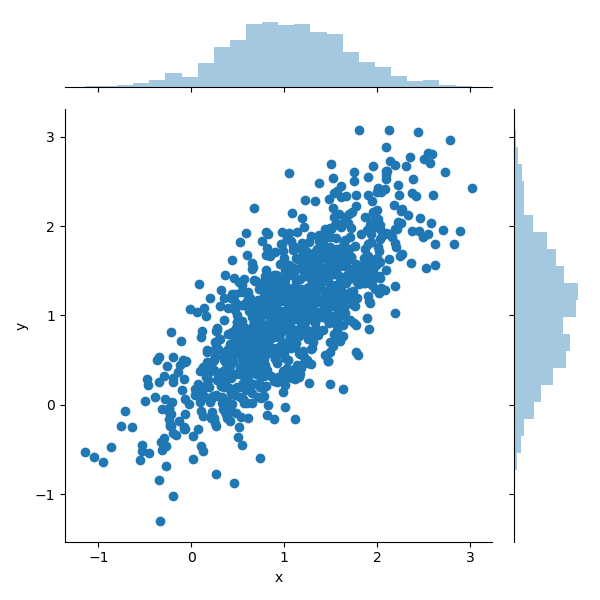

In [ ]:
warnings.filterwarnings("ignore")
# this is some scipy issue actually
df = pd.DataFrame(X.T)
df.columns = ['x', 'y']
sns.jointplot(x=df['x'], y=df['y'], kind='scatter');

# Smirnov's Theorem
Let $\eta$ be a continuous r. v. with a c.d.f. $F$.

Define inverse function: $G(u)=\inf \{x: F(x)\geq u\}$,  $0 < u < 1$  inverse function for $F$: $ F(G(x))=x$,  $0<x<1$.

What is the distribution of r.v. $\xi = F(\eta)$? 
Notice, that $ 0\leq \xi\leq 1$. 
Derive the c.d.f. of $\xi$:

$H(x)=\pr\left(\xi\leq x\right)=\pr\left(F(\eta)\leq x\right)=\pr\left(\eta \leq G(x)\right)=F(G(x))=x,\quad 0<x<1 \quad \Rightarrow\quad \xi \sim U_{[0,1]}$.

How this can be used for modeling? 
Let $\xi \sim U_{[0,1]}$ and $G=F^{-1}$ - inverse for some c.d.f., then $\eta=G(\xi)\sim F$.

#### Empirical distribution
Suppose we have observations $x^{(1)}, \ldots,x^{(m)}$ from some probability distribution with cumulative distribution $F(x)$. We can define empirical distribution on the observed values $x^{(1)}, \ldots,x^{(m)}$
$$\hat{F}_m(x)=\frac{1}{m}\sum_{i=1}^m 1_{\{x^{(i)}\leq x\}}$$

# Problem 4
$\color{blue}{\text{Fill in the implementation of the function}}$ `cdf_xy(observations)` $\color{blue}{\text{which returns x and y coordinates for an empirical function built from observations.}}$

In [ ]:
def cdf_xy(values):
    x, y = np.sort(np.random.uniform(size=len(values))), np.sort(np.random.uniform(size=len(values)))
    # YOUR CODE (START)
    x = np.sort(values)
    y = np.array([(i + 1) / len(values) for i, _ in enumerate(values)])
    # YOUR CODE (END)
    return x, y

In [ ]:
observations = np.random.normal(size=1000)

Now we can get $x$ and $y$ coordinates of the empirical function $\hat{F}_m(x)$ and construct an interpolation $\tilde{F}_m(x)$ with `np.interp` function and apply the resulting interpolated function to some distribution to get flattened version of it. We already know, what happens to normal distribution:

In [ ]:
x, y = cdf_xy(observations)
equalized_dist = np.interp(observations, x, y) # no need in interpolation here, because it returns y

In [ ]:
data = pd.DataFrame({'x':x, 'y':y})

In [ ]:
bunch = GGBunch()
plot = ggplot() + geom_histogram(aes(equalized_dist, y='..density..'), fill='blue', alpha=0.5, bins=50) + geom_histogram(aes(observations, y='..density..'), fill='red', alpha=0.5) + ggsize(400, 300) + ggtitle('Initial and flattened distributions')
bunch.add_plot(plot, 0, 0)
plot = ggplot(data) + geom_path(aes('x', 'y'), color='blue', size=1) + ggsize(400, 300) + ggtitle('Interpolated empirical cdf')
bunch.add_plot(plot, 400, 0)
bunch.show()

Initial and flattened distributions
 
 
 
 
 
 
 
 
 
 -2
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 
 
 1
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 density
 
 
 
 
 
 
 x
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 
 
 
 
 
 Interpolated empirical cdf
 
 
 
 
 
 
 
 
 
 -2
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 
 
 1
 
 
 
 
 
 
 
 
 <path d="M15.379253393620672 216.6818181818182 L15.379253393620672 216.6818181818182 L21.03179539887745 216.47524797524798 L27.98649235389766 216.26867776867778 L32.969307504106865 216.06210756210757 L33.04870286832579 215.85553735553736 L36.40160640505984 215.64896714896716 L36.60819346766114 215.44239694239695 L37.856928547559804 215.23582673582675 L43.6349340837415 215.02925652925654 L46.46308628406875 214.82268632268634 L48.73100115302354 214.61611611611613 L50.30819350042442 214.40954590954593 L50.84056616056441 213.9964054964055 L52.015649002093326 213.78983528983528 L52.274632984247575 213.58326508326508 L55.184210957873574 213.37669487669487 L55.30142943388178 213.17012467012466 L58.69800851242485 212.96355446355446 L64.97560394152215 212.75698425698425 L65.65182910332008 212.55041405041405 L66.33542911613375 212.34384384384384 L67.05141874988568 212.13727363727364 L67.53337537760746 211.93070343070343 L68.21021452583197 211.51756301756302 L69.40505051000649 211.31099281099281 L70.22870454439499 210.6912821912822 L70.6552031587963 210.484711984712 L71.66665955342465 210.2781417781418 L72.41565590575283 209.45186095186097 L72.583620976544 209.24529074529076 L73.05996514747936 208.83215033215035 L73.71374675386336 208.62558012558014 L74.4783638860424 207.7992992992993 L74.53303078544076 207.5927290927291 L75.06706897358048 207.38615888615888 L75.57837101267194 207.17958867958868 L76.04547008687003 206.97301847301847 L76.99015343744746 206.76644826644826 L77.55958908750486 206.55987805987806 L78.11550866783492 206.35330785330785 L78.96652078041058 205.94016744016744 L79.66102682117855 205.73359723359724 L80.35136553353716 204.90731640731642 L80.57676629209146 204.7007462007462 L81.15360003081112 204.2876057876058 L81.98315968758801 204.0810355810356 L82.6774647337826 203.8744653744654 L83.06880618669653 203.66789516789518 L83.93974603990426 203.25475475475477 L85.56206110825188 203.04818454818457 L85.7906192111426 202.22190372190371 L86.9272853106489 202.0153335153335 L87.90755499863498 201.3956228956229 L87.98988554351394 201.1890526890527 L88.47885573041572 200.36277186277187 L88.99434684584155 200.15620165620166 L89.84079228971557 199.74306124306125 L90.05648785198517 199.53649103649104 L90.58537602085731 199.12335062335063 L91.1765010954544 198.91678041678043 L91.96921162862648 198.0904995904996 L92.25923699923766 197.8839293839294 L92.55015203463617 197.6773591773592 L94.26154396993881 197.470788970789 L94.90857998598 196.64450814450814 L95.09937300508442 196.43793793793793 L95.98135676665109 195.6116571116571 L96.20897288030064 195.4050869050869 L97.17080090064204 194.57880607880608 L97.65338748918415 194.37223587223588 L98.11103468378948 193.54595504595505 L98.19105435195885 193.33938483938485 L99.06564607631303 192.92624442624444 L99.19159214384717 192.71967421967423 L99.6565754073604 191.8933933933934 L99.80090776735656 191.68682318682318 L100.69193969360923 190.86054236054235 L100.84382717773263 190.65397215397215 L101.6442334630991 189.82769132769133 L101.67143405892037 189.62112112112112 L102.54636

We can treat an image (flattened to a vector) as some "distribution" and apply the same technique to it. This approach is called "image equalization".

In [ ]:
colored_image = np.array(Image.open("gateway.jpg"))
image = np.mean(colored_image, axis=2)/255
image_data = image

Initial image
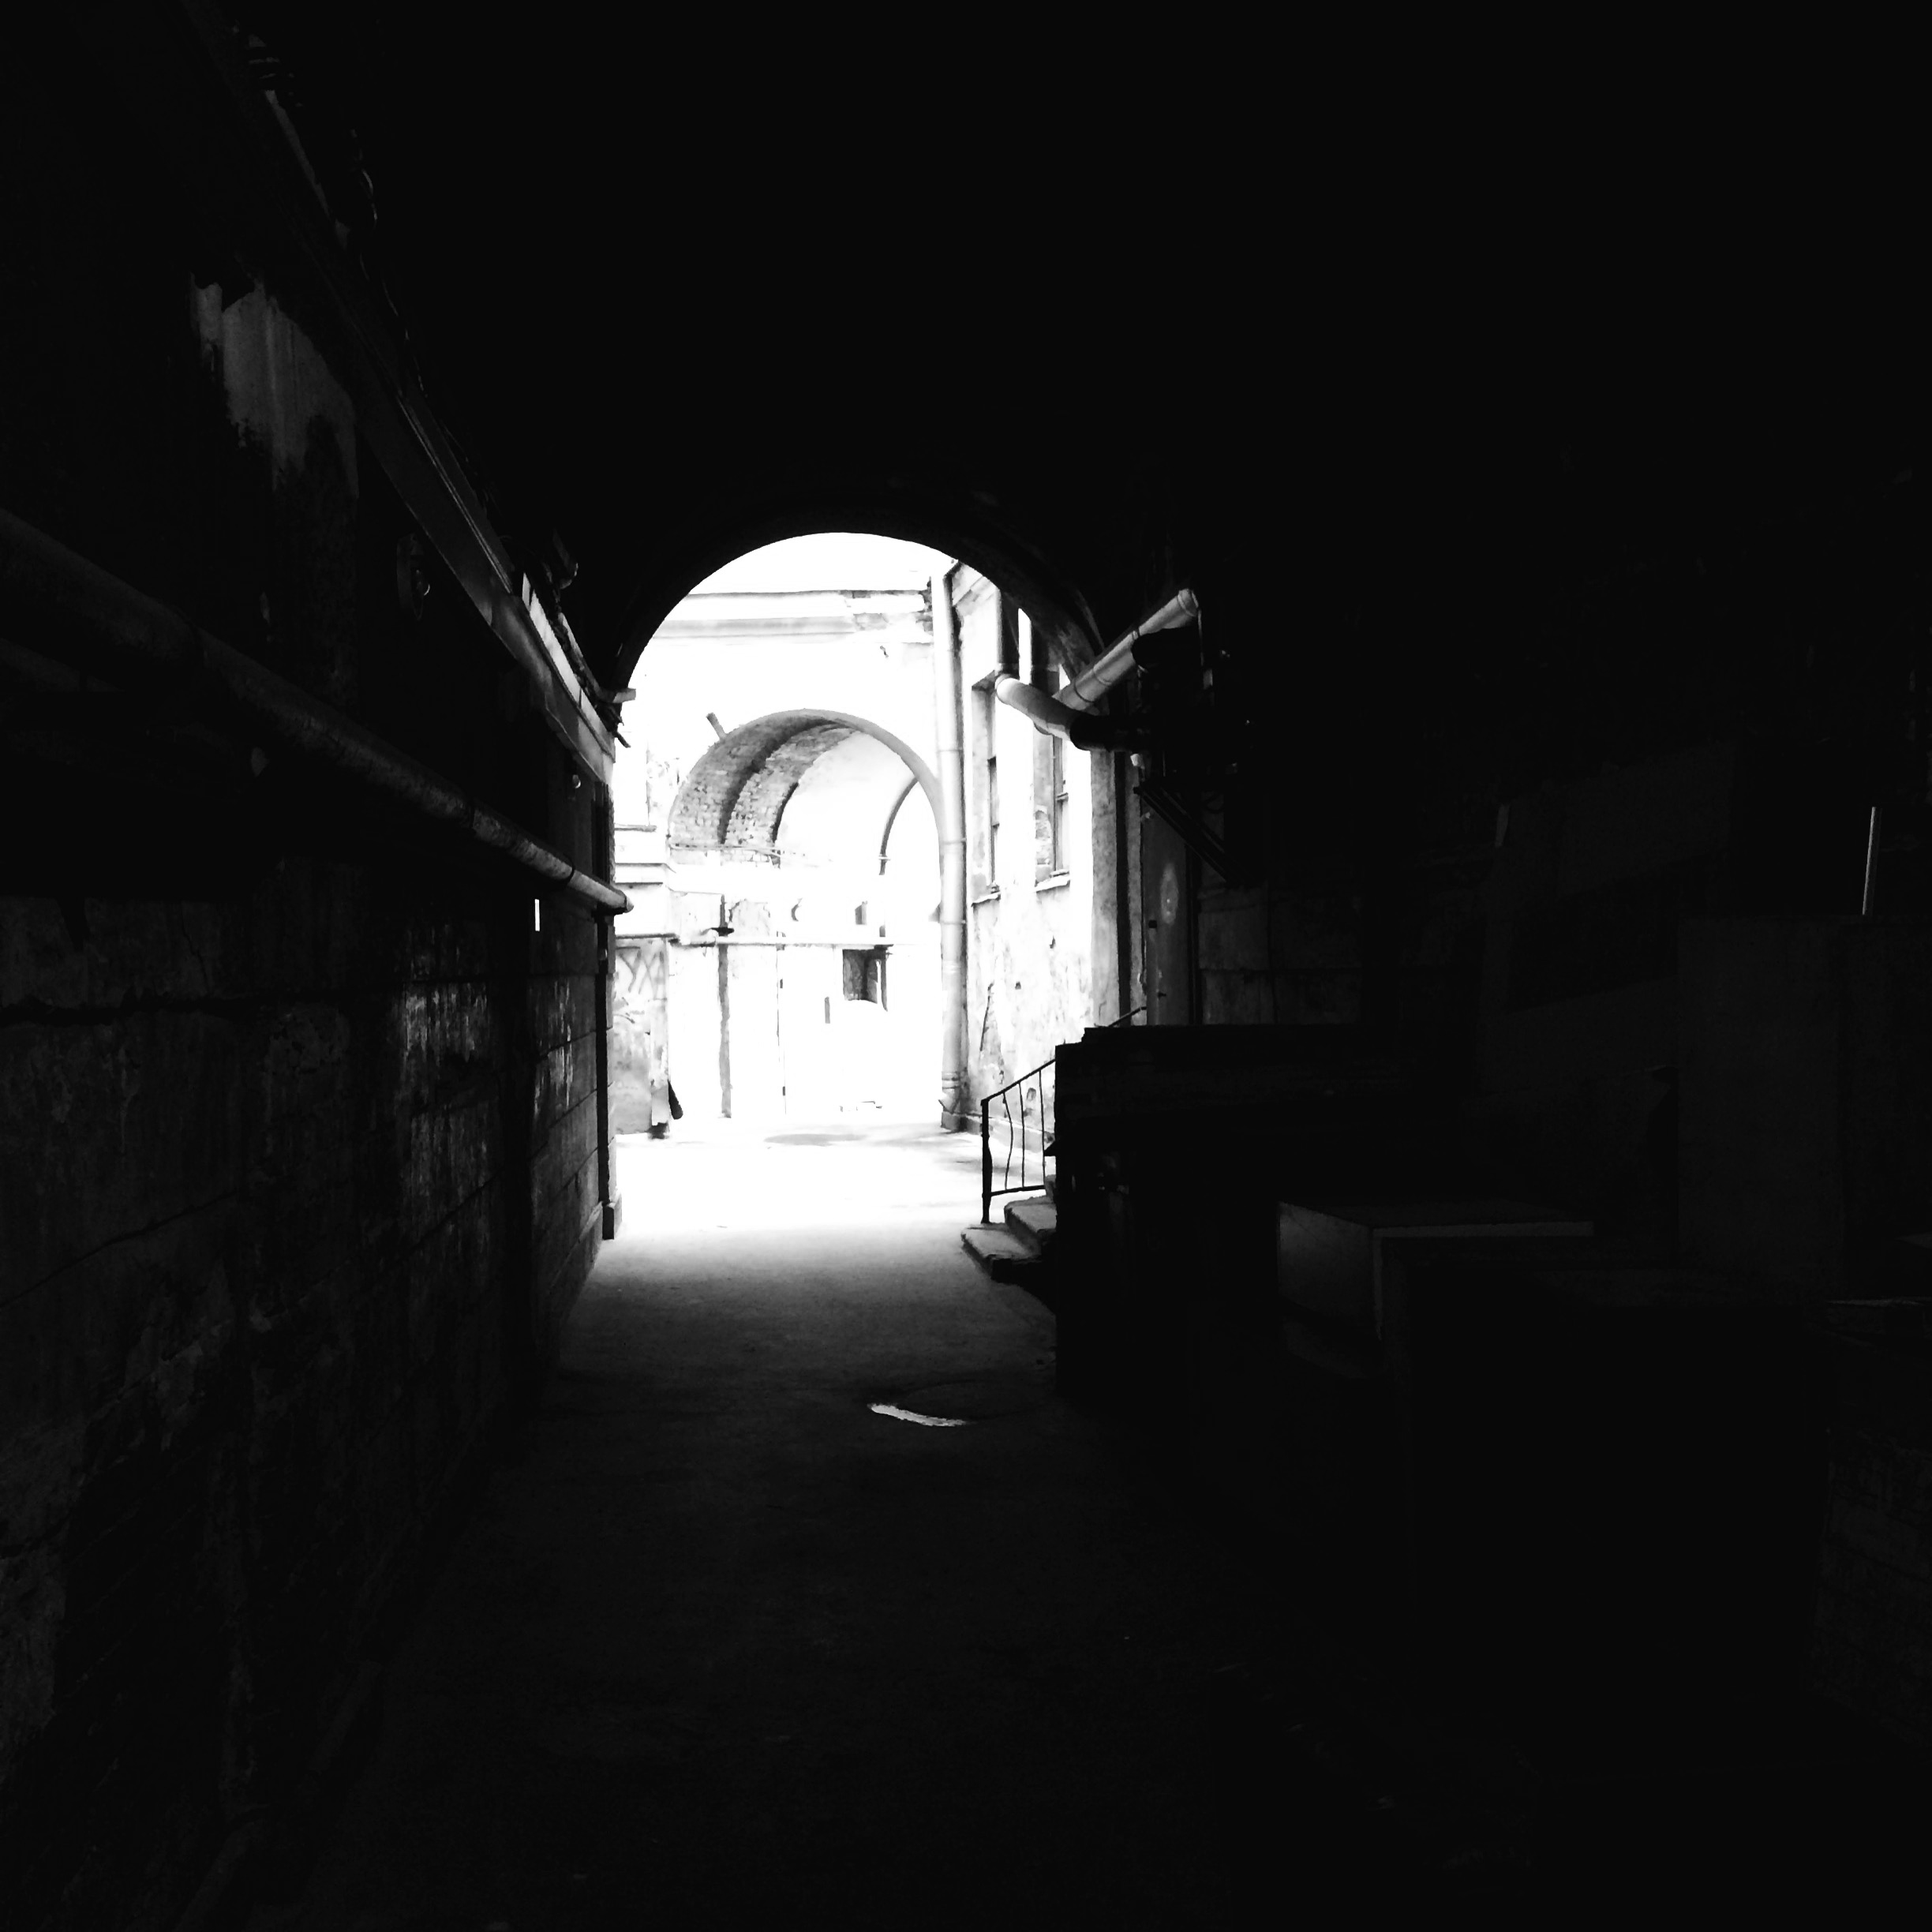

In [ ]:
ggplot() + geom_image(image_data) + theme(legend_position='none', axis_ticks='blank', axis_line='blank', axis_title='blank', axis_text='blank') + ggtitle('Initial image')

In [ ]:
flat = image.reshape(-1)
x, y = cdf_xy(flat)
equalized_image = np.interp(image, x, y)

Equalized image
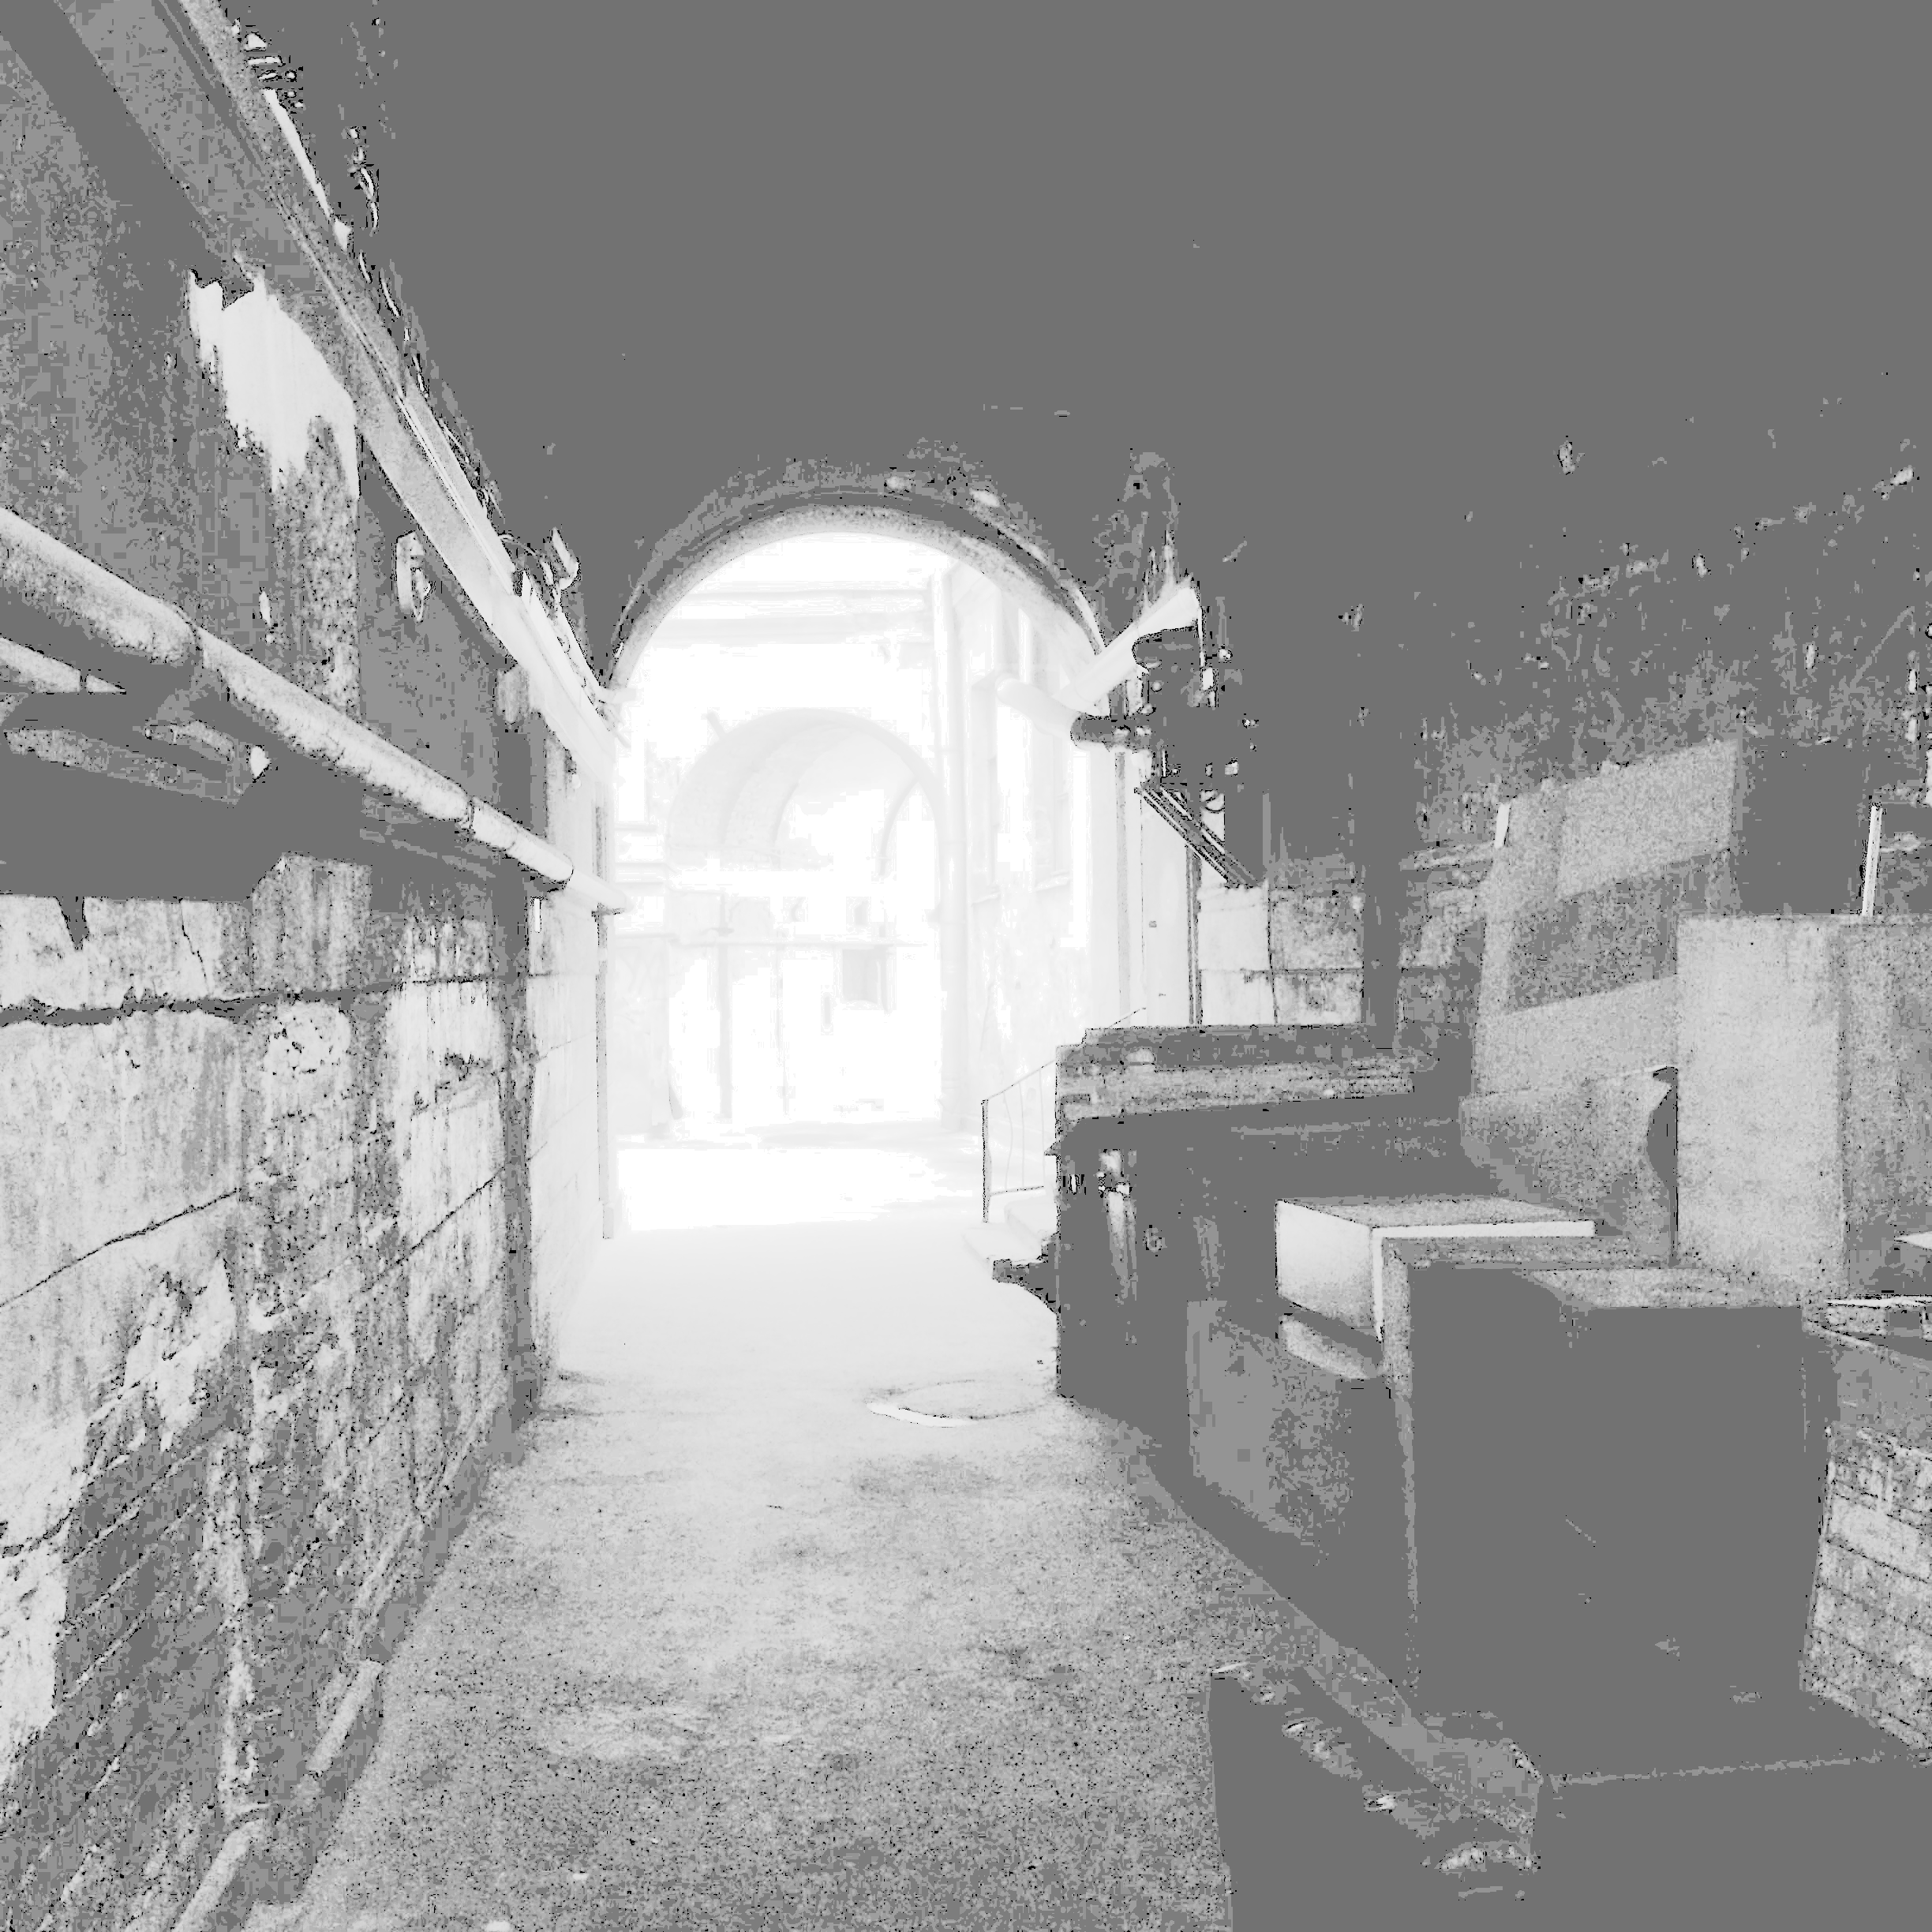

In [ ]:
ggplot() + geom_image(image_data=equalized_image) + theme(legend_position='none', axis_ticks='blank', axis_line='blank', axis_title='blank', axis_text='blank') + ggtitle('Equalized image')

# Problem 5
In this task we will solve linear regression problem with the help of batch gradient descent. We will build our model in a way similar to what is usually done in deep learning frameworks (like PyTorch or TensorFlow), which perform differentiation automatically. The main difference here will be that you'll implement the differentiation part writing formulas by yourself.

First, we read California housing data from the [StatLib repository](http://lib.stat.cmu.edu/datasets/) and saved it to a file.
Then we read data to a data frame and define feature matrix $X$ and target vector $y$. **Features** contain coordinates (lat, lon), house age, number of rooms, number of bedrooms, population in the area, number of households and average income. **Target** value is a log-cost of a house. We are going to build a model, which will predict the house cost by it's features.

In [ ]:
class fetch_california_housing:
    def __init__(self, filename='cal_housing.data', scale_target=True):
        filedata = pd.read_csv(filename, header=None).values
        self.data = filedata[:, :-1]
        self.target = filedata[:,-1]
        if scale_target:
            self.target = self.target / 100000
        self.feature_names = ['Longitude',
                      'Latitude',
                      'housingMedianAge',
                      'totalRooms',
                      'totalBedrooms',
                      'population',
                      'households',
                      'medianIncome']

In [ ]:
housing = fetch_california_housing()
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data['target'] = housing.target

In [ ]:
X, y = housing.data, housing.target

We also removed the tail observations, containing house costs clipped to a value of 5 to avoid atoms in our distribution.

In [ ]:
# remove tail observations clipped to the value 5
what_to_stay = (y < 5)
X, y = X[what_to_stay], y[what_to_stay]

Define the linear transformation coefficients - matrix $W\in\mathbb{R}^{n\times k}$ and vector $b\in\mathbb{R}^{1\times k}$ - parameters of our linear model 
$$y=xW+b$$
where feature vector (observation) $x\in\mathbb{R}^{1\times n}$ and target value $y\in\mathbb{R}^{1\times k}$. In our task $k=1$.

In [ ]:
def Linear(in_dim, out_dim):
    W = np.random.normal(loc=0, scale=0.1, size=(in_dim, out_dim))
    b = np.random.normal(loc=0, scale=0.1, size=(1, out_dim))
    return W, b

We also need to determine the way we compute the loss. Mean square loss is a common choice for a regression task.
Note, that we define two necessary methods here: `forward` and `backward`. In `forward` method we describe the function which implements loss computation. In `backward` method we write the derivative of the function, defined in `forward` method.   

In [ ]:
class MSELoss:
    def __init__(self, eps=1e-15):
        self.eps = eps

    def forward(self, output, target):
        self.target = target.squeeze()
        self.output = output.squeeze()
        return ((self.target - self.output)**2).mean()

    def backward(self):
        return self.output - self.target

    def __call__(self, output, target):
        return self.forward(output, target)

The optimization technique, which we are going to use is called Stochastic Gradient Descent and the next class implements model parameters updates according to gradient descent rule $\displaystyle \boxed{\;\hat{\theta}_{t+1}=\hat{\theta}_t-\color{blue}\eta\nabla J\;}$ where $\eta$ - is the learning rate.

In [ ]:
class SGD:
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate

    def step(self, grads, params, learning_rate=None):
        if learning_rate is None:
            learning_rate = self.learning_rate
        new_parameters = []
        for param, grad in zip(params, grads):
            param -= learning_rate*grad
            new_parameters.append(param)
        return new_parameters

We already found out, that scaling inputs can dramatically increase the convergence speed of gradient descent.

In [ ]:
def scale(X):
    X_ = copy(X)
    X_ -= X_.mean(axis=0)
    X_ /= X_.std(axis=0)
    return X_

$\color{red}{\text{Our data should be split into train, validation and test sets. We train our model using train data and validate it during training on validation data. After the model is totally trained we can check the model generalization ability using test data.}}$

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
print('X_train shape: {}, X_val shape: {}, X_test shape: {}'.format(X_train.shape, X_val.shape, X_test.shape))

X_train shape: (12574, 8), X_val shape: (3144, 8), X_test shape: (3930, 8)


We'll use batch training, so we need a data loader class, which will feed our training procedure with batches of training data. Note, that we shuffle the data after each training epoch.

In [ ]:
class DataLoader:
    def __init__(self, data, target, batch_size=100):
        self.data = data
        self.target = target
        self.batch_size = batch_size

    def next(self):
        m, _ = self.data.shape
        rand_index = np.random.choice(m, size=m)
        X, y = self.data[rand_index], self.target[rand_index]
        pos = 0
        while pos < m:
            X_batch, y_batch = X[pos:pos+self.batch_size], y[pos:pos+self.batch_size]
            yield (X_batch, y_batch)
            pos += self.batch_size

    def __call__(self):
        return self.next()

The next class implements gradient descent linear regression. It also contains `forward` and `backward` methods. In the `forward` method you define the linear transformation $\displaystyle Y=XW+b$, where $X\in\mathbb{R}^{M\times n}$ and $Y\in\mathbb{R}^{M\times k}$, where $M$ stands for a batch size. 
In the `backward` method we return gradients, calculated by a `gradients` method.

$\color{red}{\textbf{NOTE: TASK IS HERE}}$

$\color{blue}{\text{Fill in the implementation of methods}}$ `gradients` $\color{blue}{\text{and}}$ `forward` $\color{blue}{\text{below.}}$

In [ ]:
class SGDLinearRegression:
    def __init__(self, in_dim=8, out_dim=1):
        self.W, self.b = Linear(in_dim, out_dim)

    def forward(self, x):
        self.data = x
        # YOUR CODE (START)
        z = x @ self.W + self.b
        # YOUR CODE (END)
        # NO NEED: z = np.zeros(x.shape[0])
        return z

    def gradients(self):
        dW = np.zeros_like(self.W)
        db = np.zeros_like(self.b)
        # YOUR CODE (START)
        loss_backward = self.loss_function.backward()
        dW = np.sum(self.data * loss_backward.reshape(-1, 1), axis=0).reshape(-1, 1)
        db = np.sum(loss_backward).reshape(1)
        # YOUR CODE (END)
        return (dW, db)

    def backward(self, loss_function):
        self.loss_function = loss_function
        return self.gradients()

    def parameters(self):
        return (self.W, self.b)

    def update(self, params):
        self.W, self.b = params

    def __call__(self, x):
        return self.forward(x)

Define the number of epochs rto train your model.

In [ ]:
num_epochs = 50

Define dataloader, model, loss function and optimizer instances.

In [ ]:
dataloader = DataLoader(X_train, y_train)
model = SGDLinearRegression()
loss_function = MSELoss()
optimizer = SGD()

Create strwam for live plots (will be updated during training).

In [ ]:
score_stream = DataPubStream(['epoch', 'score'])
other_options = xlim(0, num_epochs) + ggsize(500, 300) + ggtitle('Validation score')
ggplot(score_stream) + geom_area(aes('epoch','score'), alpha=0.2) + other_options

Validation score
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 score
 
 
 
 
 
 
 epoch

In [ ]:
loss_stream = DataPubStream(['epoch', 'loss'])
other_options = xlim(0, num_epochs) + ggsize(500, 300) + ggtitle('Loss')
ggplot(loss_stream) + geom_area(aes('epoch','loss'), alpha=0.2) + other_options

Loss
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 loss
 
 
 
 
 
 
 epoch

Here is our main training loop. We repeat calculation `num_epoch` times. During each epoch we read batches of train data from data loader and feed them to our model. Then we put target values and obtained model outputs into our loss function and compute gradients, which are used then to update model parameters. We use validation data to evaulate our model during training.

In [ ]:
losses = []
for epoch in range(num_epochs):
    loss_sum = 0
    for data in dataloader():
        inputs, targets = data
        inputs = scale(inputs)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss_sum += loss
        grads = model.backward(loss_function)
        params = model.parameters()
        new_params = optimizer.step(grads, params)
        model.update(new_params)
    score = eval_score(model, scale(X_val), y_val)
    print(f'\r epoch: [{epoch+1}/{num_epochs}], loss: {np.round(loss_sum, 2)}, score: {np.round(score, 2)}', end='')
    score_stream.write([epoch, float(score)])
    time.sleep(0.01)
    loss_stream.write([epoch, float(loss_sum)])
    losses.append(loss_sum)

 epoch: [50/50], loss: 48.75, score: 0.61

After the training is finished we can predict targets for unseen examples from the test data set.

In [ ]:
y_pred = model(scale(X_test)).squeeze()
y_pred = clip(y_pred, 0, 5)

In [ ]:
test_data = pd.DataFrame(X_test, columns=housing.feature_names)
test_data['target'] = y_test
pred_data = pd.DataFrame(X_test, columns=housing.feature_names)
pred_data['target'] = y_pred

Let's plot actual test data and model prediction on a map (we have lat, lon coordinates in our data set).

In [ ]:
bunch = GGBunch()
plot = plot_map(test_data, legend=False) + ggtitle('Test data')
bunch.add_plot(plot, 0, 0)
plot = plot_map(pred_data, legend=False) + ggtitle('Predicted test data')
bunch.add_plot(plot, 500, 0)
bunch.show()

Test data
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 
 
 
 
 
 Predicted test data

In [ ]:
target_data = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
target_data = pd.melt(target_data)

We can also compare the empirical densities of actual and predicted data.

In [ ]:
ggplot(target_data) \
        + geom_histogram(aes(x='value', y='..density..', group='variable', fill='variable'), alpha=0.4, position='identity') \
        + ggtitle('Actual and predicted target value distributions')

Actual and predicted target value distributions
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 
 
 1
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 3
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 5
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 
 
 0.1
 
 
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 
 
 0.3
 
 
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 
 
 0.5
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 density
 
 
 
 
 
 
 value
 
 
 
 
 
 
 
 
 
 
 
 variable
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 y_test
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 y_pred

In [ ]:
counts_pred, bounds_pred = np.histogram(y_pred)
counts_test, bounds_test = np.histogram(y_test, bounds_pred)

We can use Mann-Whitney and Kolmogrorov-Smirnov tests to evaluate statstical accuracy of our model.

In [ ]:
mannwhitneyu(y_test, y_pred, alternative='two-sided')

MannwhitneyuResult(statistic=7077860.0, pvalue=1.4715656684682096e-10)

In [ ]:
ks_2samp(y_test, y_pred)

Ks_2sampResult(statistic=0.11399491094147585, pvalue=9.976952437700735e-23)

# Problem 6
Consider the Normal distribution: $\xi: N\left(a,\sigma^2 \right)$, then for any random variable $\eta$ having first two moments: $\mathbb{E}\eta=a, \mathbb{D}\eta =\sigma^2$ 
entropy for the Normal variable will be not less than the entropy for $\eta$:  $H\left(\xi\right)\geq H\left(\eta\right)$.
Prove this statement. $\color{red}{\text{Take } a=0 \text{ to simplify the derivation.}}$ 
*Hint: look into lecture notes for examples on Uniform dustribution and Exponential distribution.

#### Solution

Let's use a statement from Problem 7. We know that $\mathcal{D}_{KL}(p||q)\geq 0$. 

Let's take $p$ as density function of $\eta$ and $q$ as density of $\xi$.

$\mathcal{D}_{KL}(p||q) = \int p(x)\log p(x)dx-\int p(x)\log q(x)dx \geq 0 \iff -\int p(x)\log q(x)dx \geq -\int p(x)\log p(x)dx$ 

$\iff -\int p(x)\log q(x)dx \geq H\left(\eta\right)$

Let's look at $-\int p(x)\log q(x)dx$. Since $q$ is density of Normal Distribution with $0$ mean and $\sigma^2$ variance then

$-\int p(x)\log q(x)dx = -\int p(x)\log(\frac{1}{\sqrt{2\pi\sigma^2}} * e^{\frac{-x^2}{2\sigma^2}})dx = -\int p(x) * (-\log(\sqrt{2\pi\sigma^2}) - {\frac{x^2}{2\sigma^2}})dx = \log(\sqrt{2\pi\sigma^2}) \int p(x)dx + \frac{1}{2\sigma^2}\int p(x)x^2dx = \log(\sqrt{2\pi\sigma^2}) + \frac{1}{2} = H\left(\xi\right)$

As a consequence, we have $H\left(\xi\right) \geq H\left(\eta\right)$

#### Convex function
$$\forall x_1, x_2, \forall \lambda\in[0,1]: \; \boxed{\;f(\lambda x_1+(1-\lambda)x_2)\leq \lambda f(x_1)+(1-\lambda)f(x_2)\;}$$
#### Jensen's inequality
Let $f$ be a convex function, then
$$\boxed{\;f\left(\sum_{i=1}^n\lambda_i x_i\right)\leq \sum_{i=1}^n\lambda_i f(x_i)\;}$$
#### Information inequality
$\mathcal{D}_{KL}(p||q)\geq 0$ and equality holds iff $p=q$

# Problem 7
$\color{blue}{\text{Prove the statement of information inequality theorem.}}$

#### Proof:
Let's prove $-\mathcal{D}_{KL}(p||q)\leq 0 \iff \mathcal{D}_{KL}(p||q)\geq 0$.

As we know from lecture $$\mathcal{D}_{KL}(P||Q)=\sum_x p(x)\log \frac{p(x)}{q(x)}$$

Then $$-\mathcal{D}_{KL}(P||Q)=\sum_x p(x)\log \frac{q(x)}{p(x)}$$

Let's take as $f$ here $log$ function. $log$ is concave function thus we have inequality in the other side:

$$\boxed{\;f\left(\sum_{i=1}^n\lambda_i x_i\right) \geq \sum_{i=1}^n\lambda_i f(x_i)\;}$$

Let's take $\lambda_i = p(x)$ and $x_i = \frac{q(x)}{p(x)}$

Then we know that $$-\mathcal{D}_{KL}(P||Q) = \sum_x p(x)\log \frac{q(x)}{p(x)} \leq \log \sum_x p(x) * \frac{q(x)}{p(x)} = \log \sum_x q(x) = \log 1 = 0$$

We proved inequality, and now we need to prove equality. We know that Jensen's inequality turns into equality when $f$ is linear function (not our case) or $x_1 = x_2 = ... = x_n$.

Let's assume $x_i = \frac{q_i}{p_i} = d$. Then $1 = \sum q_i = \sum \frac{q_i}{p_i} * p_i = \sum d * p_i = d * \sum p_i = d$.

Then $d = 1 = \frac{q_i}{p_i} \iff q_i = p_i \space \forall i$ 

Q.E.D.

Note: here $q_i = q(x_i)$ and $p_i = p(x_i)$ is probability in point i (since we have discrete distribution). Here $x_i$ is different from $x_i$ in Jensen's inquality.

# Problem 8
#### Regularity conditions
On the lecture we several times used regularity conditions, which made us possible to change the order of integration and differentiation
$$\frac{\partial}{\partial \theta}\int f(\theta,x)dx=\int\frac{\partial}{\partial\theta}f(\theta, x)dx$$
Consider $X\sim U_{[0, \theta]}$ - uniformly distributed on the interval $[0, \theta]$ random variable and $\color{blue}{\text{check, if we can change the order of integration and differentiation in this case.}}$
$\color{red}{\text{NOTE:}}$ $f(\theta,x)$ here is a density function of $X$

#### Solution

To check if we can change the order we just need to calculate both sides of equality and check that they are equal in real.

As we know $f(\theta, x) = \frac{1}{\theta}$ since it is density of uniform distribution. Then

$$\frac{\partial}{\partial \theta}\int f(\theta,x)dx= \frac{\partial}{\partial \theta}\int \frac{1}{\theta}dx = \frac{\partial}{\partial \theta}( \frac{1}{\theta} \int 1dx ) = \frac{\partial}{\partial \theta}( \frac{x}{\theta} ) = -\frac{x}{\theta^2}$$

Then let's take other part of our equality.

$$\int\frac{\partial}{\partial\theta}f(\theta, x)dx = \int\frac{\partial}{\partial\theta}\frac{1}{\theta}dx = \int-\frac{1}{\theta^2}dx = -\frac{x}{\theta^2}$$

So, we CAN change the order.

Q.E.D.


### Inclusive KL-divergence

$$\mathcal{D}_{KL}(p ||q_{\theta})=\int p(x)\log\frac{p(x)}{q_{\theta}(x)}dx$$

### Exclusive KL-divergence

$$\mathcal{D}_{KL}(q_{\theta}||p)=\int q_{\theta}(x)\log\frac{q_{\theta}(x)}{p(x)}dx$$

### Problem 9

Explain the difference in minimization of inclusive versus exclusive KL-divergence.

### Solution

### Due date is $\color{blue}{7}$ of October 2019 23:59:59

### Instructions
* To submit the assignment share your workbook to me.

* Check, that you found all the tasks in the workbook.  

* Ask questions using [Discussions](https://datalore.io/workbook/YhpfCeSnpl2HSGppDxqc9Z/ZpUddgxpfVWXGKWeaZNTi8) workbook